Кирилл Лалаянц, R33352

# Лабораторная работа No7
# В -- 11
## Управляемость и наблюдаемость

Импорт необходимых для работы библиотек. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import control 
import sympy
import os
import scipy

SAVE_PATH = 'tex-report/src/figs/'
os.makedirs(SAVE_PATH, exist_ok=True)

sympy.init_printing()
p = sympy.Symbol("p")
s = sympy.Symbol("s")
t = sympy.Symbol("t")
w = sympy.Symbol("w")
I = sympy.I


def get_t(end_t = 10, dt=0.001, start_t = 0):
    return np.linspace(start_t, end_t, int(end_t / dt))

## Task1

In [41]:
task1_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])

task1_B = np.array([[-2], [5], [-3]])

task1_x1 = np.array([[-2], [1], [-1]])
task1_end_time = 3

In [97]:
def check_controllability(A, B, end_time):
    print('======== System check ==========')
    A_sympy, B_sympy = sympy.Matrix(A), sympy.Matrix(B)
    U = np.hstack((B, *[A**i for i in range(1, A.shape[0])]))
    print(f'U = {U}')
    print(f'RankU = {np.linalg.matrix_rank(U)}')
    print(f'Eigen values of A: {np.linalg.eigvals(A)}')
    A_P, A_J = A_sympy.jordan_form()
    print(f'Jordan of A: {A_J}')
    print(f'B^ = {(A_P **-1 ) * B_sympy}')
    control_gramian_matrix, control_gramian_error = get_controllability_gramian(A, B, end_time)
    print(f'Controllability Gramian at {end_time}s: {control_gramian_matrix}')
    print(f'Eigen values of Controllability Gramian at {end_time}s: {np.linalg.eigvals(control_gramian_matrix)}')
    

def check_controllability_of_point(A, B, x1):
    print('======== Point check ==========')
    U = np.hstack((B, *[A**i for i in range(1, A.shape[0])]))
    print(np.hstack((U, x1)))
    controllable = np.linalg.matrix_rank(np.hstack((U, x1))) == A.shape[0]
    print(f'{x1} in Controlable Space: {controllable}')
    return controllable

def get_controllability_gramian(A, B, end_time):
    f = lambda time: scipy.linalg.expm(A * time) @ B @ B.T @ scipy.linalg.expm(A.T * time)
    return scipy.integrate.quad_vec(f, 0, end_time)

def get_u_for_controllable(A, B, x1, end_time):
    u = []
    times = get_t(end_time)
    control_gramian_matrix, _ = get_controllability_gramian(A, B, end_time)
    for t in times:
        u.append(B.T @ scipy.linalg.expm(A.T * (end_time - t)) @ np.linalg.inv(control_gramian_matrix) @ x1)
    return np.array(u).reshape((B.shape[1], -1)), times

======== System check ==========
U = [[ -2   3   4  -1   9  16   1]
 [  5 -10 -11  -4 100 121  16]
 [ -3  10  10   3 100 100   9]]
RankU = 3
Eigen values of A: [-2.+5.j -2.-5.j -1.+0.j]
Jordan of A: Matrix([[-1, 0, 0], [0, -2 - 5*I, 0], [0, 0, -2 + 5*I]])
B^ = Matrix([[2], [-3/2 + 3*I/2], [-3/2 - 3*I/2]])
Controllability Gramian at 3s: [[ 1.20007932 -1.34167992  0.2290306 ]
 [-1.34167992  2.76344352 -1.12126199]
 [ 0.2290306  -1.12126199  1.47412296]]
Eigen values of Controllability Gramian at 3s: [4.00714483 0.27420078 1.15630018]
======== Point check ==========
[[ -2   3   4  -1   9  16   1  -2]
 [  5 -10 -11  -4 100 121  16   1]
 [ -3  10  10   3 100 100   9  -1]]
[[-2]
 [ 1]
 [-1]] in Controlable Space: True


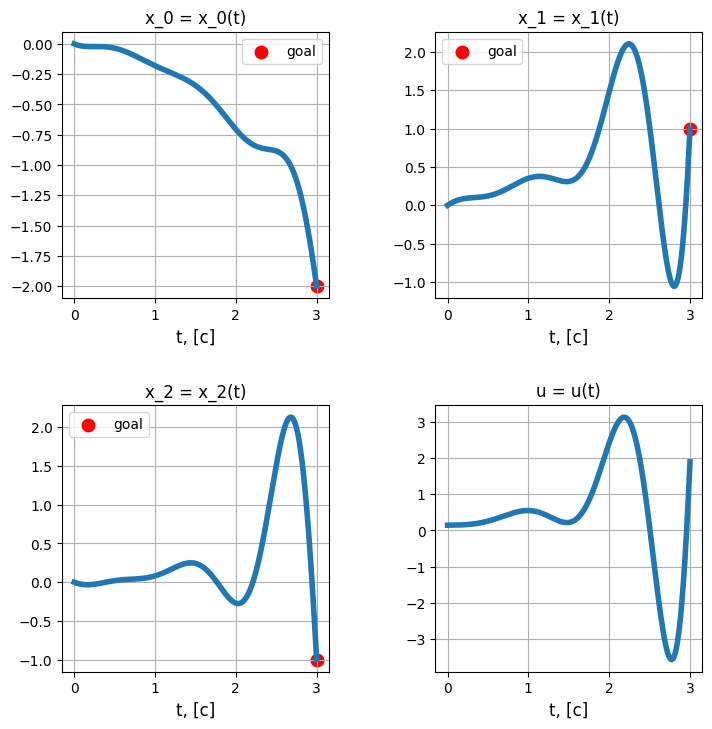

In [98]:
check_controllability(task1_A, task1_B, task1_end_time)
check_controllability_of_point(task1_A, task1_B, task1_x1)

task1_u, task1_t = get_u_for_controllable(task1_A, task1_B, task1_x1, 3)
task1_ss = control.ss(task1_A, task1_B, task1_A * 0, task1_B * 0)
output = control.forced_response(task1_ss, X0=[0,0,0], U=task1_u, T=task1_t).states

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
for i in range(3):
    axs[i//2, i % 2].plot(task1_t, output[i], linewidth=4)
    axs[i//2, i % 2].scatter(task1_end_time, task1_x1[i], color='r', linewidth=4, label='goal')
    axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
    axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
    axs[i//2, i % 2].grid(True)
    axs[i//2, i % 2].legend()
    
    
axs[1, 1].plot(task1_t, task1_u.reshape(-1), linewidth=4)
axs[1, 1].set_title(f'u = u(t)', fontsize=12)
axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
axs[1, 1].grid(True)
plt.savefig(f'{SAVE_PATH}/task1.jpg') 

## Task 2

In [99]:
task2_A = np.array([
    [3, 4, -1],
    [-10, -11, -4],
    [10, 10, 3]
])

task2_B = np.array([[2], [1], [-1]])

task2_x1 = np.array([[-2], [1], [-1]])
task2_x2 = np.array([[-5], [4], [-1]])

task2_end_time = 3

In [100]:
check_controllability(task2_A, task2_B, task2_end_time)

======== System check ==========
U = [[  2   3   4  -1   9  16   1]
 [  1 -10 -11  -4 100 121  16]
 [ -1  10  10   3 100 100   9]]
RankU = 3
Eigen values of A: [-2.+5.j -2.-5.j -1.+0.j]
Jordan of A: Matrix([[-1, 0, 0], [0, -2 - 5*I, 0], [0, 0, -2 + 5*I]])
B^ = Matrix([[0], [-1/2 + 5*I/2], [-1/2 - 5*I/2]])
Controllability Gramian at 3s: [[ 2.05602665 -1.63361588  1.63361588]
 [-1.63361588  2.40515848 -2.40515848]
 [ 1.63361588 -2.40515848  2.40515848]]
Eigen values of Controllability Gramian at 3s: [ 7.43575100e-01  6.12276851e+00 -4.05992379e-16]


In [101]:
check_controllability_of_point(task2_A, task2_B, task2_x1)

======== Point check ==========
[[  2   3   4  -1   9  16   1  -2]
 [  1 -10 -11  -4 100 121  16   1]
 [ -1  10  10   3 100 100   9  -1]]
[[-2]
 [ 1]
 [-1]] in Controlable Space: True


True

In [102]:
check_controllability_of_point(task2_A, task2_B, task2_x2)

======== Point check ==========
[[  2   3   4  -1   9  16   1  -5]
 [  1 -10 -11  -4 100 121  16   4]
 [ -1  10  10   3 100 100   9  -1]]
[[-5]
 [ 4]
 [-1]] in Controlable Space: True


True